Inspired from https://github.com/birds-on-mars/birdsonearth

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import librosa
from librosa.core import load
from librosa.output import write_wav
from scipy.io import wavfile
import os
import scipy.misc

In [8]:
class Crawler:
    '''
    A crawler class for the bird sounds API provided by
    https://www.xeno-canto.org
    Processes a number of queries to the API, dowloads respective files and
    does some postprocessing.
    Attributes:
        verbose (bool): whether to be verbose
        api_endpoint (str): defaults to the endpoint of xeno-canto
        queries (list): list of dicts specifying API queries. See api_query() for details
        df (pandas df): df to save api responses
        root (string): path to root where data is to be stored
        save_img (bool): whether to create images from the spectogram arrays
        make_wav (bool): whether to convert sounds to .wav
        make_mel_spec (bool): whether to make mel-spectrograms from the sounds
        sr (int): sampling rate in Hz
        n_mels (int): number of channels for mel-spectrograms
        hop_length (int): number of consecutive measures combined into one bin
                            for mel-spectrograms
        extract_chunks (bool): whether to extract and save fix sized chunks from spectrograms
        n_chuncks (int): number of chucks to extract from one spectogram
        len_chuncks (int):
    Note:
        mel-spectrograms are saved as ndarrays with shape (n_mels, #sec*sr/hop_length).
        The dic format for a query as taken by api_query() must be:
        {'genus':<.>, 'country':<.>, 'quality':<.>,
                    'area':<.>, 'page':<.>}
        quality can be from {'q:A', 'q>:B' , 'q<:C'}
    '''

    def __init__(self, queries=None, root=None):
        '''
        initializes default attributes.
        '''
        # Todo: implement info dataframe
        self.queries = queries
        self.verbose = True
        # API requests
        self.api_endpoint = 'http://www.xeno-canto.org/api/2/recordings'
        self.df = None
        # saving the data
        self.root = None
        self.save_img = True
        self.info_df = None
        self.min_length = .96 # in seconds, not in use
        self.convert_to_wav = True
        self.keep_mp3 = False
        self.max = None
        # processing the data
        self.make_mel_spec = True
        self.sr = 22050
        self.input_sr = 16000
        self.n_mels = 64
        self.hop_length = 256
        # extracting chuncks
        self.extract_chunks = True
        self.n_chunks = 10
        self.len_chunks = 96 # in bins of mel spec

    def api_query(self, query):
        '''
        returns a query url as expected by the Xeno-Canto API from a query dictionary
        Args:
            query (dic): in the format {'genus':<.>, 'country':<.>, 'quality':<.>,
                        'area':<.>, 'page':<.>}
        '''
        string = self.api_endpoint + '?query='

        genus = query['genus'] if 'genus' in query else None
        area = query['area'] if 'area' in query else None
        country = query['country'] if 'country' in query else None
        quality = query['quality'] if 'quality' in query else None
        page = query['page'] if 'page' in query else None

        #string=API_ENDPOINT + '?query='

        if((page is None) or (page == 0) or (page == '')):
            page = 1

        if genus is None:
            None
        else:
            string = string + str(genus)

        if area is None:
            None
        else:
            string = string + '%20' + 'area:' + str(area)

        if country is None:
            None
        else:
            string = string + '%20' + 'cnt:' + str(country)

        if quality is None:
            None
        else:
            string = string + '%20' + str(quality)

        string = string + '&page=' + str(page)

        return string


    def query(self, queries=None):
        '''
        applies all queries in self.queries and stores responses in self.df
        '''
        if queries is not None:
            self.queries = queries
        if self.queries is None:
            raise Exception('No queries have been instatiated, yet.')
        frames = []
        for i, q in enumerate(self.queries):
            query = self.api_query(q)
            if self.verbose:
                print('processing query: {}'.format(query))
            result = requests.get(query).json()['recordings']
            df_temp = pd.DataFrame(result)
            frames.append(df_temp)
        if self.verbose:
            print('updating self.df with recent query responses.')
        self.df = pd.concat(frames, ignore_index=True)


    def get_summary(self):
        '''
        returns a dataframe including all unique genii, their number of instances.
        '''
        #TODO: report total recording time
        summary = pd.DataFrame({'labels': self.df['gen'].unique()})
        summary['counts'] = [self.df['gen'].where(self.df['gen']==gen).count() \
                            for gen in summary['labels']]
        return summary


    def download(self, save_to=None):
        '''
        downloads all files in API response and generates a a directory tree with
        structure save_to/{gen}/{instances}.
        If self.convert_to_wav is true a .wav file is generated.
        If self.keep_mp3 is false resp mp3 is deleted.
        PREFER this function and use Dataset.process_xeno_canto_downloads() to
        process downloads further.
        '''
        if save_to is not None:
            self.root = save_to
        if self.df is None:
            raise Exception('No query has been applied to the API, yet. Run query() first')
        labels = self.df.gen.unique()
        if self.max is not None:
            counts = {i:0 for i in labels}
        print('downloading a maximum of {} instances/class'.format(self.max))
        for label in list(self.df.gen.unique()):
            new_dir = os.path.join(self.root, label)
            if not os.path.exists(new_dir):
                os.makedirs(new_dir)
        for index, row in self.df.iterrows():
            label = str(row.gen)
            if self.max is not None:
                if counts[label] < self.max:
                    counts[label] += 1
                else:
                    continue
            url = 'http:' + row.file
            path = os.path.join(self.root,label)
            mp3_file = os.path.join(path, '{}.mp3'.format(str(row.id)))
            wav_file = os.path.join(path, '{}.wav'.format(str(row.id)))

            if os.path.exists(wav_file) or os.path.exists(mp3_file):
                print(f"skipping {url}. file already downloaded.")
            else:
                print(f"downloading {url} to {mp3_file}")
                r = requests.get(url, timeout=60)
                open(mp3_file, 'wb').write(r.content)

                if self.convert_to_wav:
                    y, sr = load(mp3_file)
                    y *= 32768
                    y = y.astype(np.int16)
                    wavfile.write(wav_file, rate=22050, data=y)
                if not self.keep_mp3:
                    os.remove(mp3_file)


    def process_sounds(self):
        '''
        processes dowloaded files below self.root after running download_files().
        DEPRECATED Don't use this for the pretrained VGGish!
        TODO: this should go to preprocessing if kept at all
        '''
        self.info_df = self.df[['gen', 'id']].copy()
        for path, dirs, files in os.walk(self.root):
            for file in files:
                if file.endswith('.mp3'):
                    y, sr = load(os.path.join(path, file))
                    if self.convert_to_wav:
                        write_wav(os.path.join(path, file.replace('.mp3', '.wav')), y, self.input_sr)
                    if self.make_mel_spec:
                        S = librosa.feature.melspectrogram(y, sr=self.sr, n_mels=self.n_mels,
                                                    hop_length=self.hop_length)
                        log_S = librosa.amplitude_to_db(S, ref=np.max)
                        np.save(os.path.join(path, 'mel_spec.npy'), log_S)
                        if self.save_img:
                            scipy.misc.imsave(os.path.join(path, 'mel_spec.jpg'), log_S)
                        if self.extract_chunks:
                            if log_S.shape[1] < self.len_chunks:
                                print('recording {} has length {} which is shorter \
                                        than required chunk length.')
                                continue
                            self.spec_chunks(log_S, path=path)
        self.info_df.to_csv(os.path.join(self.root, 'info.csv'), sep='\t')


    def remove_processed(self):
        '''
        removes all .wav, .jpg and .npy files under self.root
        '''
        for path, dirs, files in os.walk(self.root):
            for file in files:
                if file.endswith('.wav') \
                    or file.endswith('.npy') \
                    or file.endswith('.jpg'):
                    os.remove(os.path.join(path, file))


if __name__ == '__main__':

    queries = [{'genus':'Parakeet%20Auklet'},
                 {'genus':'Crested%20Auklet'},
                 {'genus':'Layson%20Albatross'},
                 {'genus':'Least%20Auklet'},
                 {'genus':'Parakeet%20Auklet'}]

    crawler = Crawler(queries)
    crawler.query()
    summary = crawler.get_summary()
    print(summary)
    crawler.download(save_to='/content/drive/My Drive/ZooHackathon/BirdSong')

processing query: http://www.xeno-canto.org/api/2/recordings?query=Parakeet%20Auklet&page=1
processing query: http://www.xeno-canto.org/api/2/recordings?query=Crested%20Auklet&page=1
processing query: http://www.xeno-canto.org/api/2/recordings?query=Layson%20Albatross&page=1
processing query: http://www.xeno-canto.org/api/2/recordings?query=Least%20Auklet&page=1
processing query: http://www.xeno-canto.org/api/2/recordings?query=Parakeet%20Auklet&page=1
updating self.df with recent query responses.
   labels  counts
0  Aethia      25
downloading a maximum of None instances/class
downloading http://www.xeno-canto.org/101454/download to /content/drive/My Drive/ZooHackathon/BirdSong/Aethia/101454.mp3
downloading http://www.xeno-canto.org/101452/download to /content/drive/My Drive/ZooHackathon/BirdSong/Aethia/101452.mp3
downloading http://www.xeno-canto.org/352914/download to /content/drive/My Drive/ZooHackathon/BirdSong/Aethia/352914.mp3
downloading http://www.xeno-canto.org/352913/downloa

In [11]:
crawler.df.to_csv('/content/drive/My Drive/ZooHackathon/BirdSong/BirdSong.csv')

In [50]:
queries = [{'genus':'Rusty%20Blackbird'}]

crawler = Crawler(queries)
crawler.query()
summary = crawler.get_summary()
print(summary)
crawler.download(save_to='/content/drive/My Drive/ZooHackathon/BirdSong/Aethia/Rusty_Blackbird')

processing query: http://www.xeno-canto.org/api/2/recordings?query=Rusty%20Blackbird&page=1
updating self.df with recent query responses.
     labels  counts
0  Euphagus      94
downloading a maximum of None instances/class
downloading http://www.xeno-canto.org/544790/download to /content/drive/My Drive/ZooHackathon/BirdSong/Aethia/Rusty_Blackbird/Euphagus/544790.mp3
downloading http://www.xeno-canto.org/468246/download to /content/drive/My Drive/ZooHackathon/BirdSong/Aethia/Rusty_Blackbird/Euphagus/468246.mp3
downloading http://www.xeno-canto.org/444169/download to /content/drive/My Drive/ZooHackathon/BirdSong/Aethia/Rusty_Blackbird/Euphagus/444169.mp3
downloading http://www.xeno-canto.org/361340/download to /content/drive/My Drive/ZooHackathon/BirdSong/Aethia/Rusty_Blackbird/Euphagus/361340.mp3
downloading http://www.xeno-canto.org/599847/download to /content/drive/My Drive/ZooHackathon/BirdSong/Aethia/Rusty_Blackbird/Euphagus/599847.mp3
downloading http://www.xeno-canto.org/552108/d

KeyboardInterrupt: ignored

## Model

In [16]:
!pip install librosa

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
import librosa
from imutils import paths
from pathlib import Path
import os
import time
import copy
import pickle

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

In [28]:
SR = 32000

y, _ = librosa.load("/content/drive/My Drive/ZooHackathon/BirdSong/Aethia/101451.wav",
                    sr=SR,
                    res_type="kaiser_fast",
                    mono=True)

In [27]:
import IPython.display as ipd
ipd.Audio(y, rate=SR)

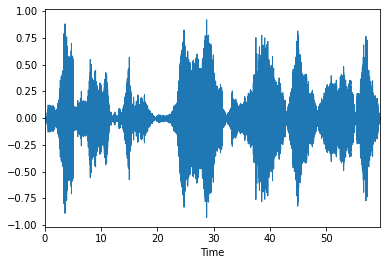

In [23]:
import librosa.display
librosa.display.waveplot(y, sr=SR);

In [31]:
!pip install torchlibrosa

In [35]:
import torchlibrosa as tl

In [3]:
class Params:
    '''
    defines all parameters needed in training.py and model.py
    TRAINING
    n_epochs (int): number of training epochs
    batch_size (int):
    val_split (float): fraction of data kept for validation
    data_root (str): path to data
    n_max (int): max number of instances loaded for training
    weights (str): path to vggish weights .hdf5 file
    '''

    def __init__(self):

        # Data
        #TODO: add options for other formats
        self.data_format = 'wav'

        # Model
        self.n_bins = 64
        self.n_frames = 96
        self.n_classes = 3

        # Training
        self.n_epochs = 100
        self.batch_size = 512
        self.val_split = .2
        self.data_root = '../data/full_urbansounds_restructured'
        # if mel_spec_root directory exists it is used and preprocessing of data_root is skipped
        # otherwise mel specs are computed from data_root
        self.mel_spec_root = '../data/full_urbansounds_specs'
        self.n_max = None
        self.weights = 'models/vggish_audioset_weights_without_fc2.h5'

        # model zoo
        self.save_model = True
        self.model_zoo = 'models'
        self.name = 'urban'

        # computing device, can be 'cuda:<GPU index>' or 'cpu'
        self.device = 'cpu'

In [30]:
params = Params()

params.name = 'BirdsSongs'

# training
params.data_format = 'wav'
params.data_root = '/content/drive/My Drive/ZooHackathon/BirdSong'
params.mel_spec_root = '/content/drive/My Drive/ZooHackathon/BirdSong/processed'
params.n_epochs = 40
params.batch_size = 256
params.device = 'cuda:0'
params.val_split = .2
params.save_model = True
params.n_max = 1000

In [5]:
# Copyright 2017 The TensorFlow Authors All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Global parameters for the VGGish model.
See vggish_slim.py for more information.
"""

# Architectural constants.
NUM_FRAMES = 96  # Frames in input mel-spectrogram patch.
NUM_BANDS = 64  # Frequency bands in input mel-spectrogram patch.
EMBEDDING_SIZE = 128  # Size of embedding layer.

# Hyperparameters used in feature and example generation.
SAMPLE_RATE = 16000
STFT_WINDOW_LENGTH_SECONDS = 0.025
STFT_HOP_LENGTH_SECONDS = 0.010
NUM_MEL_BINS = NUM_BANDS
MEL_MIN_HZ = 125
MEL_MAX_HZ = 7500
LOG_OFFSET = 0.01  # Offset used for stabilized log of input mel-spectrogram.
EXAMPLE_WINDOW_SECONDS = 0.96  # Each example contains 96 10ms frames
EXAMPLE_HOP_SECONDS = 0.96     # with zero overlap.

# Parameters used for embedding postprocessing.
PCA_EIGEN_VECTORS_NAME = 'pca_eigen_vectors'
PCA_MEANS_NAME = 'pca_means'
QUANTIZE_MIN_VAL = -2.0
QUANTIZE_MAX_VAL = +2.0

# Hyperparameters used in training.
INIT_STDDEV = 0.01  # Standard deviation used to initialize weights.
LEARNING_RATE = 1e-4  # Learning rate for the Adam optimizer.
ADAM_EPSILON = 1e-8  # Epsilon for the Adam optimizer.

# Names of ops, tensors, and features.
INPUT_OP_NAME = 'vggish/input_features'
INPUT_TENSOR_NAME = INPUT_OP_NAME + ':0'
OUTPUT_OP_NAME = 'vggish/embedding'
OUTPUT_TENSOR_NAME = OUTPUT_OP_NAME + ':0'
AUDIO_EMBEDDING_FEATURE_NAME = 'audio_embedding'

In [6]:
# Copyright 2017 The TensorFlow Authors All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Defines routines to compute mel spectrogram features from audio waveform."""

import numpy as np


def frame(data, window_length, hop_length):
  """Convert array into a sequence of successive possibly overlapping frames.
  An n-dimensional array of shape (num_samples, ...) is converted into an
  (n+1)-D array of shape (num_frames, window_length, ...), where each frame
  starts hop_length points after the preceding one.
  This is accomplished using stride_tricks, so the original data is not
  copied.  However, there is no zero-padding, so any incomplete frames at the
  end are not included.
  Args:
    data: np.array of dimension N >= 1.
    window_length: Number of samples in each frame.
    hop_length: Advance (in samples) between each window.
  Returns:
    (N+1)-D np.array with as many rows as there are complete frames that can be
    extracted.
  """
  num_samples = data.shape[0]
  num_frames = 1 + int(np.floor((num_samples - window_length) / hop_length))
  shape = (num_frames, window_length) + data.shape[1:]
  strides = (data.strides[0] * hop_length,) + data.strides
  return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)


def periodic_hann(window_length):
  """Calculate a "periodic" Hann window.
  The classic Hann window is defined as a raised cosine that starts and
  ends on zero, and where every value appears twice, except the middle
  point for an odd-length window.  Matlab calls this a "symmetric" window
  and np.hanning() returns it.  However, for Fourier analysis, this
  actually represents just over one cycle of a period N-1 cosine, and
  thus is not compactly expressed on a length-N Fourier basis.  Instead,
  it's better to use a raised cosine that ends just before the final
  zero value - i.e. a complete cycle of a period-N cosine.  Matlab
  calls this a "periodic" window. This routine calculates it.
  Args:
    window_length: The number of points in the returned window.
  Returns:
    A 1D np.array containing the periodic hann window.
  """
  return 0.5 - (0.5 * np.cos(2 * np.pi / window_length *
                             np.arange(window_length)))


def stft_magnitude(signal, fft_length,
                   hop_length=None,
                   window_length=None):
  """Calculate the short-time Fourier transform magnitude.
  Args:
    signal: 1D np.array of the input time-domain signal.
    fft_length: Size of the FFT to apply.
    hop_length: Advance (in samples) between each frame passed to FFT.
    window_length: Length of each block of samples to pass to FFT.
  Returns:
    2D np.array where each row contains the magnitudes of the fft_length/2+1
    unique values of the FFT for the corresponding frame of input samples.
  """
  frames = frame(signal, window_length, hop_length)
  # Apply frame window to each frame. We use a periodic Hann (cosine of period
  # window_length) instead of the symmetric Hann of np.hanning (period
  # window_length-1).
  window = periodic_hann(window_length)
  windowed_frames = frames * window
  return np.abs(np.fft.rfft(windowed_frames, int(fft_length)))


# Mel spectrum constants and functions.
_MEL_BREAK_FREQUENCY_HERTZ = 700.0
_MEL_HIGH_FREQUENCY_Q = 1127.0


def hertz_to_mel(frequencies_hertz):
  """Convert frequencies to mel scale using HTK formula.
  Args:
    frequencies_hertz: Scalar or np.array of frequencies in hertz.
  Returns:
    Object of same size as frequencies_hertz containing corresponding values
    on the mel scale.
  """
  return _MEL_HIGH_FREQUENCY_Q * np.log(
      1.0 + (frequencies_hertz / _MEL_BREAK_FREQUENCY_HERTZ))


def spectrogram_to_mel_matrix(num_mel_bins=20,
                              num_spectrogram_bins=129,
                              audio_sample_rate=8000,
                              lower_edge_hertz=125.0,
                              upper_edge_hertz=3800.0):
  """Return a matrix that can post-multiply spectrogram rows to make mel.
  Returns a np.array matrix A that can be used to post-multiply a matrix S of
  spectrogram values (STFT magnitudes) arranged as frames x bins to generate a
  "mel spectrogram" M of frames x num_mel_bins.  M = S A.
  The classic HTK algorithm exploits the complementarity of adjacent mel bands
  to multiply each FFT bin by only one mel weight, then add it, with positive
  and negative signs, to the two adjacent mel bands to which that bin
  contributes.  Here, by expressing this operation as a matrix multiply, we go
  from num_fft multiplies per frame (plus around 2*num_fft adds) to around
  num_fft^2 multiplies and adds.  However, because these are all presumably
  accomplished in a single call to np.dot(), it's not clear which approach is
  faster in Python.  The matrix multiplication has the attraction of being more
  general and flexible, and much easier to read.
  Args:
    num_mel_bins: How many bands in the resulting mel spectrum.  This is
      the number of columns in the output matrix.
    num_spectrogram_bins: How many bins there are in the source spectrogram
      data, which is understood to be fft_size/2 + 1, i.e. the spectrogram
      only contains the nonredundant FFT bins.
    audio_sample_rate: Samples per second of the audio at the input to the
      spectrogram. We need this to figure out the actual frequencies for
      each spectrogram bin, which dictates how they are mapped into mel.
    lower_edge_hertz: Lower bound on the frequencies to be included in the mel
      spectrum.  This corresponds to the lower edge of the lowest triangular
      band.
    upper_edge_hertz: The desired top edge of the highest frequency band.
  Returns:
    An np.array with shape (num_spectrogram_bins, num_mel_bins).
  Raises:
    ValueError: if frequency edges are incorrectly ordered or out of range.
  """
  nyquist_hertz = audio_sample_rate / 2.
  if lower_edge_hertz < 0.0:
    raise ValueError("lower_edge_hertz %.1f must be >= 0" % lower_edge_hertz)
  if lower_edge_hertz >= upper_edge_hertz:
    raise ValueError("lower_edge_hertz %.1f >= upper_edge_hertz %.1f" %
                     (lower_edge_hertz, upper_edge_hertz))
  if upper_edge_hertz > nyquist_hertz:
    raise ValueError("upper_edge_hertz %.1f is greater than Nyquist %.1f" %
                     (upper_edge_hertz, nyquist_hertz))
  spectrogram_bins_hertz = np.linspace(0.0, nyquist_hertz, num_spectrogram_bins)
  spectrogram_bins_mel = hertz_to_mel(spectrogram_bins_hertz)
  # The i'th mel band (starting from i=1) has center frequency
  # band_edges_mel[i], lower edge band_edges_mel[i-1], and higher edge
  # band_edges_mel[i+1].  Thus, we need num_mel_bins + 2 values in
  # the band_edges_mel arrays.
  band_edges_mel = np.linspace(hertz_to_mel(lower_edge_hertz),
                               hertz_to_mel(upper_edge_hertz), num_mel_bins + 2)
  # Matrix to post-multiply feature arrays whose rows are num_spectrogram_bins
  # of spectrogram values.
  mel_weights_matrix = np.empty((num_spectrogram_bins, num_mel_bins))
  for i in range(num_mel_bins):
    lower_edge_mel, center_mel, upper_edge_mel = band_edges_mel[i:i + 3]
    # Calculate lower and upper slopes for every spectrogram bin.
    # Line segments are linear in the *mel* domain, not hertz.
    lower_slope = ((spectrogram_bins_mel - lower_edge_mel) /
                   (center_mel - lower_edge_mel))
    upper_slope = ((upper_edge_mel - spectrogram_bins_mel) /
                   (upper_edge_mel - center_mel))
    # .. then intersect them with each other and zero.
    mel_weights_matrix[:, i] = np.maximum(0.0, np.minimum(lower_slope,
                                                          upper_slope))
  # HTK excludes the spectrogram DC bin; make sure it always gets a zero
  # coefficient.
  mel_weights_matrix[0, :] = 0.0
  return mel_weights_matrix


def log_mel_spectrogram(data,
                        audio_sample_rate=8000,
                        log_offset=0.0,
                        window_length_secs=0.025,
                        hop_length_secs=0.010,
                        **kwargs):
  """Convert waveform to a log magnitude mel-frequency spectrogram.
  Args:
    data: 1D np.array of waveform data.
    audio_sample_rate: The sampling rate of data.
    log_offset: Add this to values when taking log to avoid -Infs.
    window_length_secs: Duration of each window to analyze.
    hop_length_secs: Advance between successive analysis windows.
    **kwargs: Additional arguments to pass to spectrogram_to_mel_matrix.
  Returns:
    2D np.array of (num_frames, num_mel_bins) consisting of log mel filterbank
    magnitudes for successive frames.
  """
  window_length_samples = int(round(audio_sample_rate * window_length_secs))
  hop_length_samples = int(round(audio_sample_rate * hop_length_secs))
  fft_length = 2 ** int(np.ceil(np.log(window_length_samples) / np.log(2.0)))
  spectrogram = stft_magnitude(
      data,
      fft_length=fft_length,
      hop_length=hop_length_samples,
      window_length=window_length_samples)
  mel_spectrogram = np.dot(spectrogram, spectrogram_to_mel_matrix(
      num_spectrogram_bins=spectrogram.shape[1],
      audio_sample_rate=audio_sample_rate, **kwargs))
  return np.log(mel_spectrogram + log_offset)

In [7]:
# Copyright 2017 The TensorFlow Authors All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Compute input examples for VGGish from audio waveform."""

import numpy as np
import resampy
from scipy.io import wavfile



def waveform_to_examples(data, sample_rate):
  """Converts audio waveform into an array of examples for VGGish.
  Args:
    data: np.array of either one dimension (mono) or two dimensions
      (multi-channel, with the outer dimension representing channels).
      Each sample is generally expected to lie in the range [-1.0, +1.0],
      although this is not required.
    sample_rate: Sample rate of data.
  Returns:
    3-D np.array of shape [num_examples, num_frames, num_bands] which represents
    a sequence of examples, each of which contains a patch of log mel
    spectrogram, covering num_frames frames of audio and num_bands mel frequency
    bands, where the frame length is vggish_params.STFT_HOP_LENGTH_SECONDS.
  """
  # Convert to mono.
  if len(data.shape) > 1:
    data = np.mean(data, axis=1)
  # Resample to the rate assumed by VGGish.
  if sample_rate !=  SAMPLE_RATE:
    data = resampy.resample(data, sample_rate,  SAMPLE_RATE)

  # Compute log mel spectrogram features.
  log_mel = log_mel_spectrogram(
      data,
      audio_sample_rate= SAMPLE_RATE,
      log_offset= LOG_OFFSET,
      window_length_secs= STFT_WINDOW_LENGTH_SECONDS,
      hop_length_secs= STFT_HOP_LENGTH_SECONDS,
      num_mel_bins= NUM_MEL_BINS,
      lower_edge_hertz= MEL_MIN_HZ,
      upper_edge_hertz= MEL_MAX_HZ)

  # Frame features into examples.
  features_sample_rate = 1.0 /  STFT_HOP_LENGTH_SECONDS
  example_window_length = int(round(
       EXAMPLE_WINDOW_SECONDS * features_sample_rate))
  example_hop_length = int(round(
       EXAMPLE_HOP_SECONDS * features_sample_rate))

  log_mel_examples = frame(
      log_mel,
      window_length=example_window_length,
      hop_length=example_hop_length)
  return log_mel_examples


def wavfile_to_examples(wav_file):
  """Convenience wrapper around waveform_to_examples() for a common WAV format.
  Args:
    wav_file: String path to a file, or a file-like object. The file
    is assumed to contain WAV audio data with signed 16-bit PCM samples.
  Returns:
    See waveform_to_examples.
  """
  sr, wav_data = wavfile.read(wav_file)
  assert wav_data.dtype == np.int16, 'Bad sample type: %r' % wav_data.dtype
  samples = wav_data / 32768.0  # Convert to [-1.0, +1.0]
  return waveform_to_examples(samples, sr)

In [8]:
def preprocess(src, dst):
    y, sr = load(src)
    y *= 32768
    y = y.astype(np.int16)
    wavfile.write(dst, rate=22050, data=y)


def process_wavs_for_training(params):
    '''
    iterates through data under root that must have the structure
    root/{classes}/{instances}. Data must be in integer(!) .wav format.
    Under save_to the same subdirectories save_to/{classes}
    are generated and for every instance vggish compatible inputs are generated according
    to the parameters specified in vggish_params.py
    Args:
        root (string): path to data root
        saveto (string): path to root where processed data is stored
    '''
    if os.path.exists(params.mel_spec_root):
        print('spectrograms seem to have been computed')
        print('delete {} manually and rerun preprocessing or keep goint to use what is there.'.format(
        params.mel_spec_root))
        return
    labels = os.listdir(params.data_root)
    for label in os.listdir(params.data_root):
        if not os.path.isdir(os.path.join(params.data_root, label)): continue
        print('processing data for label {}'.format(label))
        os.makedirs(os.path.join(params.mel_spec_root, label))
        for file in os.listdir(os.path.join(params.data_root, label)):
            data = wavfile_to_examples(os.path.join(params.data_root, label, file))
            for i in range(data.shape[0]):
                np.save(os.path.join(params.mel_spec_root, label, file[:-4]+str(i)+'.npy'), data[i])


def summary(params):
    labels = [f for f in os.listdir(params.data_root)
                if os.path.isdir(os.path.join(params.data_root, f))]
    counts = [len(os.listdir(os.path.join(params.data_root, label))) for label in labels]
    df = pd.DataFrame(data={'labels':labels, 'instances':counts})
    print('the following classes and numer of instances are found:\n')
    print(df)
    processed = os.path.exists(params.mel_spec_root)
    if processed:
        print('spectrograms for the data seem to have been computed under {} \
                and will be used for training'.format(params.mel_spec_root))
    else:
        print('spectrograms for the given data need to be computed by running \
                preprocessing')

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler


class MelSpecDataset(Dataset):
    '''
    A subclass of pytorch's Dataset class to handle bird sounds data as processed
    by the xeno-canto crawler class.
    '''

    def __init__(self, params):
        '''
        initializes the Data set to a root directory data_root
        '''
        print('initialization')
        self.root = params.mel_spec_root
        self.max_size = params.n_max # max #instances / class used for training
        self.labels = []
        self.n_instances = []
        self.df = pd.DataFrame(data={'label':[], 'file':[], 'path':[]})
        self.load_data()

    def load_data(self):
        '''
        iterates through the path given by self.root that must have structure
        root/{classes}/{chunks} where chunks must be ndarrays as produced by
        vggish_input and respective labels arrays and paths in self.df dataframe.
        '''
        label_list = os.listdir(self.root)
        label_list.sort()
        try:
            label_list.remove('.DS_Store')
        except:
            None
        for label in label_list:
            self.labels.append(label)
            paths = [os.path.join(self.root, label, file) \
                    for file in os.listdir(os.path.join(self.root, label))]
            if self.max_size is not None:
                paths = paths[:self.max_size]
            self.n_instances.append(len(paths))
            print('loading {} spectrograms for class {}'.format(self.n_instances[-1], label))
            arrays = [np.load(path) for path in paths]
            labels_for_files = [label]*len(arrays)
            label_df = pd.DataFrame(data={'label':labels_for_files, 'file':arrays, \
                                    'path':paths})
            self.df = self.df.append(label_df, ignore_index=True)
        print('done data loading')

    def __getitem__(self, idx):
        '''
        returns chunk at idx as defined in self.df dataframe plus its label as
        a tensor (1xN_framesxN_bins) and int resp.
        '''
        label = self.df.at[idx, 'label']
        array = self.df.at[idx, 'file']
        #array = np.load(os.path.join(self.root, label, file))
        tensor = torch.from_numpy(array)
        return tensor.unsqueeze(0).float(), self.labels.index(label)

    def __len__(self):
        return len(self.df.index)


def make_loaders(dataset, batch_size, val_split):
    '''
    takes a dataset and sets up train and test dataloaders for it
    Args:
        dataset (object of Dataset subclass):
        batch_size (int):
        val_split (float): fraction of data for kept for validation
        shuffle_data (bool): if true indices are shuffled befor dividing them
    returns:
        respective train and test loaders (objects of the DataLoader class)
    '''
    # make list of indices
    indices = list(range(len(dataset)))
    np.random.shuffle(indices) # is necessary b/c inidices are ordered by labels
    split_idx = int(np.floor(val_split*len(dataset)))
    train_indices = indices[split_idx:]
    val_indices = indices[:split_idx]
    # make samplers
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(val_indices)
    # make dataloaders
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    return train_loader, test_loader

def process_xeno_canto_downloads(root, save_to):
    '''
    iterates through data under root that must have the structure
    root/{classes}/{instances}. Under save_to the same subdirectories save_to/{classes}
    are generated and for every instance vggish compatible inputs are generated according
    to the parameters specified in vggish_params.py
    Args:
        root (string): path to data root
        saveto (string): path to root where processed data is stored
    '''
    label_list = os.listdir(root)
    try:
        label_list.remove('.DS_Store')
    except:
        None
    for label in label_list:
        if not os.path.isdir(os.path.join(root, label)): continue
        print('prcossing data for label {}'.format(label))
        os.makedirs(os.path.join(save_to, label))
        for file in os.listdir(os.path.join(root, label)):
            print('processing:', os.path.join(root, label, file))
            data = wavfile_to_examples(os.path.join(root, label, file))
            for i in range(data.shape[0]):
                np.save(os.path.join(save_to, label, file[:-4]+str(i)+'.npy'), data[i])

In [10]:
process_wavs_for_training(params)

spectrograms seem to have been computed
delete /content/drive/My Drive/ZooHackathon/BirdSong/processed manually and rerun preprocessing or keep goint to use what is there.


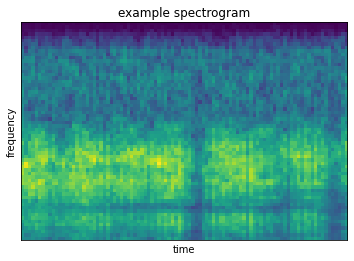

In [11]:
spec = np.load('/content/drive/My Drive/ZooHackathon/BirdSong/processed/Least_Auklet/1014511.npy')
plt.imshow(spec.T)
plt.xticks([])
plt.yticks([])
plt.xlabel('time')
plt.ylabel('frequency')
plt.title('example spectrogram')
plt.show()

In [36]:
import h5py as h5
from torch.nn.functional import relu, softmax
from torch.utils.data import DataLoader

class VGGish(nn.Module):

    def __init__(self, params):

        super(VGGish, self).__init__()

        self.n_bins = params.n_bins
        self.n_frames = params.n_frames
        self.out_dims = int(params.n_bins / 2**4 * params.n_frames / 2**4)
        self.n_classes = params.n_classes
        self.weights = params.weights
        self.model_zoo = params.model_zoo
        self.name = params.name

        # convolutional bottom part
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1))
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1, 1))
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=(3, 3), padding=(1, 1))
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1))
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # fully connected top part
        self.classifier = nn.Sequential(
            nn.Linear(self.out_dims*512, 1028),
            nn.ReLU(),
            nn.Linear(1028, 1028),
            nn.ReLU(),
            nn.Linear(1028, self.n_classes)
        )

    def forward(self, X):

        a = self.pool1(relu(self.conv1(X)))
        a = self.pool2(relu(self.conv2(a)))
        a = relu(self.conv3_1(a))
        a = relu(self.conv3_2(a))
        a = self.pool3(a)
        a = relu(self.conv4_1(a))
        a = relu(self.conv4_2(a))
        a = self.pool4(a)
        a = a.reshape((a.size(0), -1))
        a = self.classifier(a)
        a = softmax(a)
        return a

    def init_weights(self, file=None):
        '''
        laods pretrained weights from an .hdf5 file. File structure must match exactly.
        Args:
            file (string): path to .hdf5 file containing VGGish weights
        '''

        if file is not None:
            file = file
        else:
            file = self.weights

        # loading weights from file
        with h5.File(file, 'r') as f:

            conv1 = f['conv1']['conv1']
            kernels1 = torch.from_numpy(conv1['kernel:0'][()].transpose(3, 2, 1, 0))
            biases1 = torch.from_numpy(conv1['bias:0'][()])
            conv2 = f['conv2']['conv2']
            kernels2 = torch.from_numpy(conv2['kernel:0'][()].transpose(3, 2, 1, 0))
            biases2 = torch.from_numpy(conv2['bias:0'][()])
            conv3_1 = f['conv3']['conv3_1']['conv3']['conv3_1']
            kernels3_1 = torch.from_numpy(conv3_1['kernel:0'][()].transpose(3, 2, 1, 0))
            biases3_1 = torch.from_numpy(conv3_1['bias:0'][()])
            conv3_2 = f['conv3']['conv3_2']['conv3']['conv3_2']
            kernels3_2 = torch.from_numpy(conv3_2['kernel:0'][()].transpose(3, 2, 1, 0))
            biases3_2 = torch.from_numpy(conv3_2['bias:0'][()])
            conv4_1 = f['conv4']['conv4_1']['conv4']['conv4_1']
            kernels4_1 = torch.from_numpy(conv4_1['kernel:0'][()].transpose(3, 2, 1, 0))
            biases4_1 = torch.from_numpy(conv4_1['bias:0'][()])
            conv4_2 = f['conv4']['conv4_2']['conv4']['conv4_2']
            kernels4_2 = torch.from_numpy(conv4_2['kernel:0'][()].transpose(3, 2, 1, 0))
            biases4_2 = torch.from_numpy(conv4_2['bias:0'][()])

            # assigning weights to layers
            self.conv1.weight.data = kernels1
            self.conv1.bias.data = biases1
            self.conv2.weight.data = kernels2
            self.conv2.bias.data = biases2
            self.conv3_1.weight.data = kernels3_1
            self.conv3_1.bias.data = biases3_1
            self.conv3_2.weight.data = kernels3_2
            self.conv3_2.bias.data = biases3_2
            self.conv4_1.weight.data = kernels4_1
            self.conv4_1.bias.data = biases4_1
            self.conv4_2.weight.data = kernels4_2
            self.conv4_2.bias.data = biases4_2

    def freeze_bottom(self):
        '''
        freezes the convolutional bottom part of the model.
        '''
        for layer in self.children():
            if isinstance(layer, nn.Conv2d):
                layer.weight.requires_grad = False
                layer.bias.requires_grad = False

    def save_weights(self):
        torch.save(self.state_dict(),
                    '/content/drive/My Drive/ZooHackathon/BirdSong/' + self.name+'.pt')
        return


class VGGish_w_top(nn.Module):

    def __init__(self, params, top=False):

        super(VGGish, self).__init__()

        self.n_bins = params.n_bins
        self.n_frames = params.n_frames
        self.out_dims = int(params.n_bins / 2**4 * params.n_frames / 2**4)
        self.n_classes = params.n_classes
        self.weights = params.weights
        self.weights_to = params.weights_to
        self.name = params.name
        self.top = top

        # convolutional bottom part
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1))
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1, 1))
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=(3, 3), padding=(1, 1))
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1))
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        if self.top:
            self.fc1 = nn.Linear(self.out_dims*512, 4096)
            self.fc2 = nn.Linear(4096, 4096)
            self.fc3 = nn.Linear(4096, 128)

    def forward(self, X):

        a = self.pool1(relu(self.conv1(X)))
        a = self.pool2(relu(self.conv2(a)))
        a = relu(self.conv3_1(a))
        a = relu(self.conv3_2(a))
        a = self.pool3(a)
        a = relu(self.conv4_1(a))
        a = relu(self.conv4_2(a))
        a = self.pool4(a)
        return a

    def init_weights(self, file=None):
        '''
        laods pretrained weights from an .hdf5 file. File structure must match exactly.
        Args:
            file (string): path to .hdf5 file containing VGGish weights
        '''

        if file is not None:
            file = file
        else:
            file = self.weights

        # loading weights from file
        with h5.File(file, 'r') as f:
            conv1 = f['conv1']['conv1']
            kernels1 = torch.from_numpy(conv1['kernel:0'][()].transpose(3, 2, 1, 0))
            biases1 = torch.from_numpy(conv1['bias:0'][()])
            conv2 = f['conv2']['conv2']
            kernels2 = torch.from_numpy(conv2['kernel:0'][()].transpose(3, 2, 1, 0))
            biases2 = torch.from_numpy(conv2['bias:0'][()])
            conv3_1 = f['conv3']['conv3_1']['conv3']['conv3_1']
            kernels3_1 = torch.from_numpy(conv3_1['kernel:0'][()].transpose(3, 2, 1, 0))
            biases3_1 = torch.from_numpy(conv3_1['bias:0'][()])
            conv3_2 = f['conv3']['conv3_2']['conv3']['conv3_2']
            kernels3_2 = torch.from_numpy(conv3_2['kernel:0'][()].transpose(3, 2, 1, 0))
            biases3_2 = torch.from_numpy(conv3_2['bias:0'][()])
            conv4_1 = f['conv4']['conv4_1']['conv4']['conv4_1']
            kernels4_1 = torch.from_numpy(conv4_1['kernel:0'][()].transpose(3, 2, 1, 0))
            biases4_1 = torch.from_numpy(conv4_1['bias:0'][()])
            conv4_2 = f['conv4']['conv4_2']['conv4']['conv4_2']
            kernels4_2 = torch.from_numpy(conv4_2['kernel:0'][()].transpose(3, 2, 1, 0))
            biases4_2 = torch.from_numpy(conv4_2['bias:0'][()])

            # assigning weights to layers
            self.conv1.weight.data = kernels1
            self.conv1.bias.data = biases1
            self.conv2.weight.data = kernels2
            self.conv2.bias.data = biases2
            self.conv3_1.weight.data = kernels3_1
            self.conv3_1.bias.data = biases3_1
            self.conv3_2.weight.data = kernels3_2
            self.conv3_2.bias.data = biases3_2
            self.conv4_1.weight.data = kernels4_1
            self.conv4_1.bias.data = biases4_1
            self.conv4_2.weight.data = kernels4_2
            self.conv4_2.bias.data = biases4_2

    def freeze_bottom(self):
        '''
        freezes the convolutional bottom part of the model.
        '''
        for layer in self.children():
            if isinstance(layer, nn.Conv2d):
                layer.weight.requires_grad = False
                layer.bias.requires_grad = False

    def save_weights(self, path=None):
        if path is None:
            path = os.path.join(self.weights_to, self.name+'.pt')
        torch.save(self.state_dict(), path)

In [18]:
class Trainer():
    '''
    class to provide framework for training a network.
    Attributes:
        TRAINING
        n_epochs (int): number of epochs of training
        model (nn.Module instance): model to be trained
        dataset (instance of DataSet subclass): to handle data
        train_loader (DataLoader instance): loader handling training data
        test_loader (DataLoader instance): loader handling test data
        criterion (nn.Loss function): loss function for training
        optimizer (nn.optim instance): optimizer for model params
        batch_size (int): batch size
        save_params (string): path to where
    '''

    def __init__(self, model, dataset, criterion, optimizer, params, device):
        '''
        initializes training from a parameter class object
        Args:
            model (nn.Module subclass instance): model to be training
            dataset (DataSet subclass instance): providing data
            criterion (nn.Loss instance): loss function
            optimizer (nn.optim instance): optimizer for model parameters
            params (params class instance): providing all relevant parameters
        '''

        self.model = model

        # training
        self.n_epochs = params.n_epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.batch_size = params.batch_size
        self.device = device

        # data loading
        self.dataset = dataset
        self.val_split = params.val_split
        self._init_dataloaders()

        # state
        self.current_epoch = 0

        # stats
        self.train_loss = []
        self.test_loss = []
        self.train_acc = []
        self.test_acc = []


    def _init_dataloaders(self):
        '''
        from self.dataset initializes self.train_loader and self.test_loader
        according to params
        '''
        # make list of indices
        indices = list(range(len(self.dataset)))
        np.random.shuffle(indices) # is necessary b/c inidices are ordered by labels
        split_idx = int(np.floor(self.val_split*len(self.dataset)))
        train_indices = indices[split_idx:]
        val_indices = indices[:split_idx]
        # make samplers
        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SubsetRandomSampler(val_indices)
        # make dataloaders
        self.train_loader = DataLoader(self.dataset, self.batch_size, sampler=train_sampler)
        self.test_loader = DataLoader(self.dataset, self.batch_size, sampler=test_sampler)


    def _train(self):
        '''
        performs one training iteration through the training data plus backpropagation
        '''
        self.model.train()
        epoch_loss = 0.
        total_correct = 0
        for i, (data, target) in enumerate(self.train_loader):
            data = data.to(self.device)
            target = target.to(self.device)
            out = self.model(data)
            loss = self.criterion(out, target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            epoch_loss += loss.detach().cpu().numpy()
            pred = out.argmax(1)
            total_correct += (pred == target).sum().cpu().numpy()
        self.train_acc.append(total_correct / len(self.train_loader.sampler))
        self.train_loss.append(epoch_loss / len(self.train_loader.sampler))


    def _test(self):
        '''
        performs one iteration through the evaluation set
        '''
        self.model.eval()
        test_loss = 0.
        total_correct = 0
        for i, (data, target) in enumerate(self.test_loader):
            data = data.to(self.device)
            target = target.to(self.device)
            out = self.model(data)
            loss = self.criterion(out, target)
            test_loss += loss.detach().cpu().numpy()
            pred = out.argmax(1)
            total_correct += (pred == target).sum().cpu().numpy()
        self.test_acc.append(total_correct / len(self.test_loader.sampler))
        self.test_loss.append(test_loss / len(self.test_loader.sampler))


    def run_training(self):
        '''
        executes a training routine over self.n_epochs
        '''
        for e in range(self.n_epochs):
            print('\nEpoch:', e)
            self._train()
            #print('training loss:', train_loss)
            print('training accuracy:', self.train_acc[-1])
            self._test()
            #print('test loss:', test_loss)
            print('test accuracy:', self.test_acc[-1])

In [34]:
def start_training_with(params):
    '''
    takes a params object and expects ready to be used spectrograms
    in params.mel_spec_root.
    Sets up all requirements for training, runs the training and returns the
    trained model
    '''
    # setup
    device = torch.device(params.device)
    n_classes = len(os.listdir(params.mel_spec_root))
    params.n_classes = n_classes
    print('setting up training for {} classes'.format(n_classes))
    dataset = MelSpecDataset(params)
    net = VGGish(params)
    net.init_weights('/content/drive/My Drive/ZooHackathon/BirdSong/vggish_audioset_weights_without_fc2.h5')
    net.freeze_bottom()
    new_top = torch.nn.Linear(net.out_dims*512, net.n_classes)
    net.classifier = new_top
    net.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    trainer = Trainer(net, dataset, criterion, optimizer, params, device)

    # starting training
    print('start training on {} for {} epochs'.format(device, params.n_epochs))
    trainer.run_training()

    # saving model weights and class labels
    if params.save_model:
        print('saving weights and class labels')
        net.save_weights()
        print(dataset.labels)
        with open('/content/drive/My Drive/ZooHackathon/BirdSong/BirdSongClassifier.pkl', 'wb') as f:
            pickle.dump(dataset.labels, f)

    return net, dataset.labels

In [37]:
model, labels = start_training_with(params)

setting up training for 5 classes
initialization
loading 0 spectrograms for class .ipynb_checkpoints
loading 113 spectrograms for class Crested_Auklet
loading 548 spectrograms for class Least_Auklet
loading 68 spectrograms for class Parakeet_Auklet
loading 445 spectrograms for class Rusty_Blackbird
done data loading
start training on cuda:0 for 40 epochs

Epoch: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


training accuracy: 0.601063829787234
test accuracy: 0.7991452991452992

Epoch: 1
training accuracy: 0.7819148936170213
test accuracy: 0.7948717948717948

Epoch: 2
training accuracy: 0.7851063829787234
test accuracy: 0.7991452991452992

Epoch: 3
training accuracy: 0.7914893617021277
test accuracy: 0.7991452991452992

Epoch: 4
training accuracy: 0.7978723404255319
test accuracy: 0.7948717948717948

Epoch: 5
training accuracy: 0.801063829787234
test accuracy: 0.7948717948717948

Epoch: 6
training accuracy: 0.8063829787234043
test accuracy: 0.7948717948717948

Epoch: 7
training accuracy: 0.8095744680851064
test accuracy: 0.7948717948717948

Epoch: 8
training accuracy: 0.8159574468085107
test accuracy: 0.8034188034188035

Epoch: 9
training accuracy: 0.8202127659574469
test accuracy: 0.8076923076923077

Epoch: 10
training accuracy: 0.824468085106383
test accuracy: 0.811965811965812

Epoch: 11
training accuracy: 0.8287234042553191
test accuracy: 0.8205128205128205

Epoch: 12
training accuracy

In [56]:
def load_model_with(params, path, ptPath):
    print('loading model')
    # load class labels
    with open(path, 'rb') as f:
        labels = pickle.load(f)
    # init network and load weights
    params.n_classes = len(labels)
    device = torch.device(params.device)
    net = VGGish(params)
    new_top = torch.nn.Linear(net.out_dims*512, net.n_classes)
    net.classifier = new_top
    net.load_state_dict(torch.load(ptPath,
                        map_location=device))
    net.to(device)
    net.eval()
    print('model for labels {} is ready'.format(labels))
    return net, labels


def predict(net, labels, files, params):
    print('starting inference')
    device = torch.device(params.device)
    predictions = []
    probs = []
    for i, file in enumerate(files):
        filename = os.path.splitext(os.path.basename(file))[0]
        processed = filename + '_proc.wav'
        preprocess(file, processed)
        data = wavfile_to_examples(processed)
        data = torch.from_numpy(data).unsqueeze(1).float()
        data = data.to(device)
        net.to(device)
        out = net(data)
        # # for each spectrogram/row index of max probability
        # pred = np.argmax(out.detach().cpu().numpy(), axis=1)
        # # find most frequent index over all spectrograms
        # consensus = np.bincount(pred).argmax()
        # print('file {} sounds like a {} to me'.format(i, labels[consensus]))
        # mean probabilities for each col/class over all spectrograms
        mean_probs = np.mean(out.detach().cpu().numpy(), axis=0)
        # find index of max mean_probs
        idx = np.argmax(mean_probs)
        print('file {} sounds like a {} to me'.format(i, labels[idx]))
        print('my guesses are: ')
        for j, label in enumerate(labels):
            print('{0}: {1:.04f}'.format(label, mean_probs[j]))
        # predictions.append(labels[consensus])
        predictions.append(labels[idx])
        probs.append(mean_probs)
        os.remove(processed)
    return predictions, probs


In [57]:
files = ['/content/drive/My Drive/ZooHackathon/BirdSong/Rusty_Blackbird/544790.wav']

In [58]:
net, labels = load_model_with(params, '/content/drive/My Drive/ZooHackathon/BirdSong/BirdSongClassifier.pkl', '/content/drive/My Drive/ZooHackathon/BirdSong/BirdsSongs.pt')
predictions, probs = predict(net, labels, files, params)

loading model
model for labels ['.ipynb_checkpoints', 'Crested_Auklet', 'Least_Auklet', 'Parakeet_Auklet', 'Rusty_Blackbird'] is ready
starting inference
file 0 sounds like a Rusty_Blackbird to me
my guesses are: 
.ipynb_checkpoints: 0.0003
Crested_Auklet: 0.0017
Least_Auklet: 0.0146
Parakeet_Auklet: 0.0003
Rusty_Blackbird: 0.9831


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
